# 분석에 필요한 라이브러리 설치

In [1]:
# 필요한 라이브러리 설치
!pip install plotnine kmodes tqdm ipypb

     |████████████████████████████████| 1.2 MB 8.6 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 111 kB 4.2 MB/s eta 0:00:01


In [4]:
import sqlite3
import pandas as pd
import numpy as np

In [5]:
# 경고 메세지 안보이게 설정
import warnings
warnings.filterwarnings('ignore')

In [6]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [8]:
from plotnine import *
import plotnine

In [9]:
from sklearn.preprocessing import MinMaxScaler
from kmodes.kprototypes import KPrototypes

In [24]:
from tqdm import tqdm_notebook
import time
from ipypb import ipb

# 데이터베이스에서 테이블 불러오기

In [10]:
# 영수증 번호가 E인 것들 select + 1번 + 5번 연결
con = sqlite3.connect("lpoint.db", isolation_level=None) # lpoint db 생성 or 연결

df2 = pd.read_sql('''
SELECT P.cust, D.ma_fem_dv, D.ages, D.zon_hlv, P.rct_no, P.de_dt, P.chnl_dv, P.cop_c, P.pd_c, C.clac_hlv_nm, C.clac_mcls_nm, C.pd_nm, P.de_hr, P.buy_am, P.buy_ct
FROM PDDE AS P, DEMO AS D, PD_CLAC AS C
WHERE P.cust = D.cust AND P.pd_c = C.pd_c AND P.rct_no LIKE 'E%'
GROUP BY P.cust, D.ma_fem_dv, D.ages, D.zon_hlv, P.rct_no, P.de_dt, P.chnl_dv, P.cop_c, P.pd_c, C.clac_hlv_nm, C.clac_mcls_nm, C.pd_nm, P.de_hr, P.buy_am, P.buy_ct;
''', con, index_col=None)

con.close()

# 불러온 테이블 컬럼명 한글로 재설정

In [11]:
df2.columns = ['고객번호', '성별', '연령대', '거주지분류대코드', '영수증번호', '구매일자', '채널구분', '제휴사', 
              '상품코드', '상품대분류명', '상품중분류명', '상품소분류명',
              '구매시간', '구매금액', '구매수량']

# 군집화에 사용할 필요한 컬럼명만 가져오기

In [12]:
ndf2 = df2[['성별', '연령대', '거주지분류대코드', '제휴사', '상품대분류명', '구매시간', '구매금액', '구매수량']]

# 구매월 변수 추가

In [13]:
# 구매월 추가
ndf2['구매월'] = df2['구매일자'].map(lambda x: str(x)[4:6]+'월')

# 숫자형 변수 최대최소스케일링

In [14]:
scaled_X = MinMaxScaler().fit_transform(ndf2[['구매시간', '구매금액', '구매수량']])
ndf2[['구매시간', '구매금액', '구매수량']] = scaled_X

# Categorical 변수 정해주기

In [15]:
# Get the position of categorical columns
catcol = [ndf2.columns.get_loc(col) for col in list(ndf2.select_dtypes('object').columns)]
print('Categorical columns {}'.format(list(ndf2.select_dtypes('object').columns)))
print('Categorical columns position : {}'.format(catcol))

Categorical columns ['성별', '연령대', '거주지분류대코드', '제휴사', '상품대분류명']
Categorical columns position : [0, 1, 2, 3, 4]


# 데이터 프레임을 행렬 형태로 만들어주기

In [16]:
# convert dataframe to matrix
dfmatrix = ndf2.to_numpy()
dfmatrix

array([['여성', '30대', 'Z11', ..., 0.0019174718632772533, 0.0, 0.0],
       ['여성', '30대', 'Z11', ..., 0.0007526989705538311, 0.0, 0.0],
       ['여성', '30대', 'Z11', ..., 0.0008379262553872522, 0.0, 0.0],
       ...,
       ['여성', '50대', 'Z17', ..., 0.004872017737502519, 0.0, 0.0],
       ['여성', '50대', 'Z17', ..., 0.01264190520481608, 0.0,
        0.2727272727272727],
       ['여성', '50대', 'Z17', ..., 0.007102131690643706, 0.0,
        0.36363636363636365]], dtype=object)

# Elbow Method : Cluster 간의 거리의 합을 나타내는 값이 급격히 떨어지는 구간을 군집 개수로 설정

In [26]:
# Choose optimal K using Elbow method
cost = []
for cluster in ipb(range(1, 7)):
    try:
        kprototype = KPrototypes(n_jobs = -1, max_iter = 50, n_clusters = cluster, init = 'Huang',
                                 random_state = 0, verbose = True)
        kprototype.fit_predict(dfmatrix, categorical = catcol)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
    time.sleep(0.1)

 [████████████████████████████████████████████████████████████] 6/6 [05:24:01<01:41:36, 3240.24s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 0, ncost: 198763.083870216
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 0, ncost: 198763.083870216
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 0, ncost: 198763.083870216
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 0, ncost: 198763.083870216
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 0, ncost: 198763.083870216
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 0, ncost: 198763.083870216
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 0, ncost: 198763.083870216
Init: initializing c

- Best run was number 3라는 안내문을 확인할 수 있었음

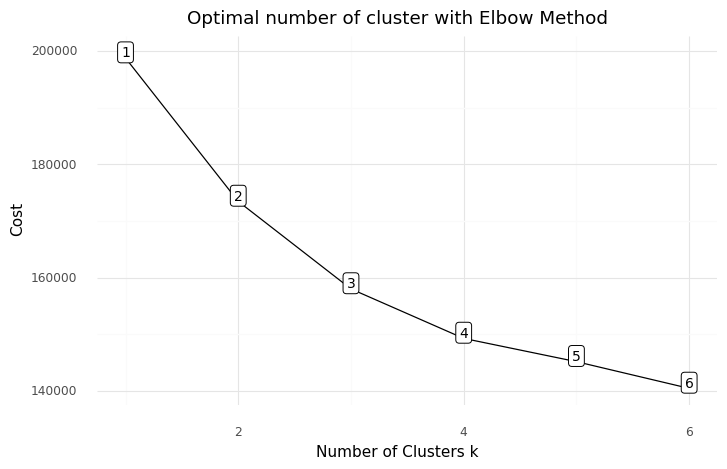

<ggplot: (8770376084209)>

In [27]:
# Elbow 메소드 시각화
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(1, 7), 'Cost':cost})
# Data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

- 위의 결과 2번 혹은 3번이 제일 좋아 보임 (위의 코드 결과에서는 best run was 3 였으므로 우선 3으로 해보고 군집 결과가 별로 안좋은 것 같으면 2번으로 해보는 것이 좋을듯)

In [28]:
df_cost

,Cluster,Cost
0,1,198763.083870
1,2,173469.059021
2,3,158027.441741
3,4,149298.396265
4,5,145195.616925
5,6,140482.286747


# 군집개수 선택 후 모델 적합하기

In [ ]:
# Fit the cluster
# n_clusters = 3으로 한다
kprototype = KPrototypes(n_jobs = -1, max_iter = 50, n_clusters = 3, init = 'Huang', random_state = 0)
kprototype.fit_predict(dfmatrix, categorical = catcol)

# 기존 데이터 프레임에 분류된 군집 추가하기

In [ ]:
#new column for cluster labels associated with each subject
df2['cluster'] = kprototype.labels_ # 모든 컬럼 들어있는 데이터프레임에 군집 추가
ndf2['cluster'] = kprototype.labels_ # 군집화에 사용된 컬럼 들어있는 데이터프레임에 군집 추가

In [ ]:
df2.head()

In [ ]:
ndf2.head()